In [67]:
import cv2
import torch
import h5py
import numpy as np
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.synthesize_program import *
from sketch2code.methods.lstm import *
from s14_supervise_baseline import *
from s01_toy_img_feature import make_vocab as make_img_vocab

### Purpose

Supervised for program synthesis

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#examples 1750


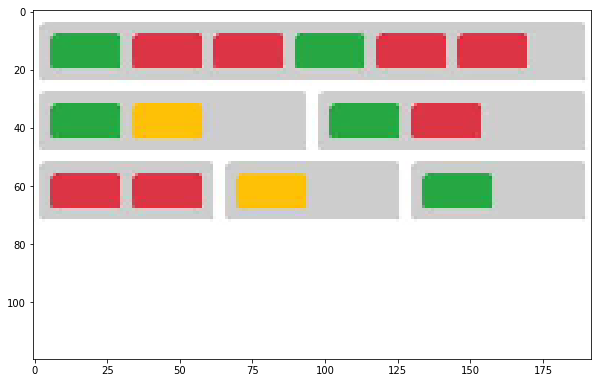

In [70]:
tags, oimages = load_dataset("toy")
print("#examples", len(tags))

def preprocess_img():
    global oimages
    return [shrink_img(img, 0.4, cv2.INTER_NEAREST).transpose((2, 0, 1)) for img in norm_rgb_imgs(oimages[:])]

images = cache_arrays("toy.shrink.imgs", preprocess_img)
plt.imshow(1 - images[0].transpose(1, 2, 0))
images = torch.tensor(images, device=device)

### Prepare datasets

In [10]:
vocab, ivocab = make_toy_vocab()
min_length = 10

def get_datasets():
    global images
    assert len(images) == len(tags)
    indices = list(range(len(images)))
    
    train_examples = make_dataset(indices[:1250], tags, vocab, min_length)
    valid_examples = make_dataset(indices[1250:1500], tags, vocab, min_length)
    test_examples = make_dataset(indices[1500:], tags, vocab, min_length)

    return train_examples, valid_examples, test_examples

train_examples, valid_examples, test_examples = get_datasets()

#examples 1250
#examples 250
#examples 250


In [14]:
# TODO: uncomment to double check if the datasets are correct
render_engine = RemoteRenderEngine.get_instance(tags[0].to_html(), 480, 300)
example2img = lambda e: HTMLProgram.from_int_tokens(e.context_tokens, ivocab).render_img(render_engine)
# verify_dataset(oimages, train_examples, example2img)
verify_dataset(oimages, valid_examples, example2img)
# verify_dataset(oimages, test_examples, example2img)

### Define the model

In [12]:
class BLSuper5(nn.Module):
    
    def __init__(self, img_h: int, img_w: int, img_repr_size: int, dsl_vocab: Dict[int, str], dsl_embedding_dim: int, dsl_hidden_dim: int):
        super().__init__()
        self.img_w = img_w
        self.img_h = img_h
        self.img_repr_size = img_repr_size
        self.dsl_vocab = dsl_vocab
        self.dsl_hidden_dim = dsl_hidden_dim
        self.dsl_embedding_dim = dsl_embedding_dim

        self.__build_model()
    
    def __build_model(self):
        # network compute features of target image
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm2d(16, momentum=0.9)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(32, momentum=0.9)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(64, momentum=0.9)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        imgsize = [self.img_h, self.img_w]
        for i, s in enumerate(imgsize):
            s = conv2d_size_out(s, 7, 1)
            s = pool2d_size_out(s, 3, 2)
            s = conv2d_size_out(s, 5, 1)
            s = pool2d_size_out(s, 3, 2)
            s = conv2d_size_out(s, 5, 1)
            s = pool2d_size_out(s, 3, 2)
            imgsize[i] = s
        
        linear_input_size = imgsize[0] * imgsize[1] * 64
        
        self.fc1 = nn.Linear(linear_input_size, self.img_repr_size)
        self.bn4 = nn.BatchNorm2d(self.img_repr_size, momentum=0.9)
        
        # lstm that compute the context of the program
        self.word_embedding = nn.Embedding(
            num_embeddings=len(self.dsl_vocab), embedding_dim=self.dsl_embedding_dim, padding_idx=vocab['<pad>'])
        self.lstm = LSTMNoEmbedding(
            input_size=self.dsl_embedding_dim + self.img_repr_size,
            hidden_size=self.dsl_hidden_dim,
            n_layers=1)
        self.lstm2token = nn.Linear(self.dsl_hidden_dim, len(self.dsl_vocab))

    def forward(self, x1, x2, x2_lens):
        """
            @x1: desired images (batch: N x C x W x H)
            @x2: current programs (batch: N x T)
            @x2_lens: lengths of current programs (N)
        """
        batch_size = x2_lens.shape[0]
        
        # STEP 1: compute output from CNN
        # X is N x C x W x H
        x1 = self.pool1(F.selu(self.bn1(self.conv1(x1))))
        x1 = self.pool2(F.selu(self.bn2(self.conv2(x1))))
        x1 = self.pool3(F.selu(self.bn3(self.conv3(x1))))
        
        # flatten to N x (C * W * H)
        x1 = x1.view(batch_size, -1)
        x1 = F.relu(self.fc1(x1))
        
        # STEP 2: compute feature from lstm
        x2 = self.word_embedding(x2)
        x1 = x1.view(batch_size, 1, self.img_repr_size).expand(batch_size, x2.shape[1], x1.shape[1])
        x2 = torch.cat([x1, x2], dim=2)
        x2, (hn, cn) = self.lstm(x2, x2_lens, self.lstm.init_hidden(x2, batch_size))
        # flatten from N x T x H to N x (T * H)
        hn = hn.view(batch_size, -1)
        # flatten from N x T x H to (N * T) x H
        x2 = x2.contiguous().view(-1, self.dsl_hidden_dim)
        nts = F.log_softmax(self.lstm2token(x2), dim=1)
        return nts        

In [77]:
model = BLSuper5(img_h=120, img_w=192, img_repr_size=1024, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=512).to(device)
print(model.train())

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

histories = train(model, scheduler, optimizer, images, (train_examples, valid_examples, test_examples), n_epoches=100, eval_test_freq=5, batch_size=100, device=device)

BLSuper5(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12160, out_features=1024, bias=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (word_embedding): Embedding(15, 100, padding_idx=0)
  (lstm): LSTMNoEmbedding(
    (lstm): LSTM(1124, 512, batch_first=True)


KeyboardInterrupt: 

#### Evaluate

In [37]:
cpu_device = torch.device('cpu')

In [48]:
checkpoint = torch.load("/home/rook/workspace/CSCI559/Project/sketch2code/runs/s05_exp/run_38/model.bin")
model2 = BLSuper5(img_h=120, img_w=192, img_repr_size=1024, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=512).to(cpu_device)
model2.load_state_dict(checkpoint['model'])
# eval(model2, images, valid_examples, device)

In [30]:
bimgs, bx, bnx, bxlen, sorted_idx, batch_examples = next(iter_batch(200, images, train_examples, True, device))
gimg, x = bimgs[0], bx[0]
p = HTMLProgram.from_int_tokens([w for w in x.tolist() if w > 0], ivocab)

gimg = gimg.permute((1, 2, 0)).clone().cpu().numpy()
eimg = shrink_img(norm_rgb_imgs(p.render_img(render_engine)), 0.4, cv2.INTER_NEAREST)
matches = ((eimg == gimg).sum() / np.prod(eimg.shape))
assert matches == 1.0, matches

AssertionError: 0.5493055555555556

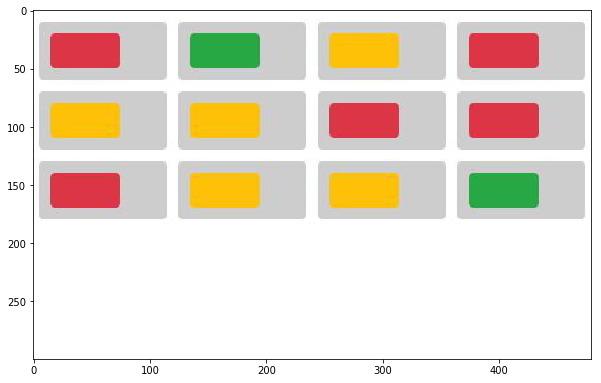

In [71]:
plt.imshow(oimages[1033])

[1033, 347, 1132, 817, 1088, 962, 496, 594, 458, 855, 1006, 754, 772, 524, 864, 1214, 18, 653, 1072, 87, 298, 798, 193, 31, 53, 223, 393, 674, 648, 1081, 1143, 986, 820, 1231, 539, 1208, 303, 952, 1108, 736, 1191, 392, 823, 93, 618, 553, 404, 540, 720, 996, 586, 1123, 1016, 348, 723, 621, 102, 682, 1233, 1172, 387, 776, 634, 824, 270, 804, 219, 490, 1030, 974, 841, 1109, 407, 1091, 162, 1206, 340, 1053, 667, 468, 581, 1173, 1027, 612, 685, 1063, 434, 1056, 1064, 846, 1230, 616, 75, 960, 603, 232, 408, 1, 1099, 463, 1093, 628, 455, 812, 614, 1012, 56, 862, 1192, 1069, 886, 913, 261, 1242, 155, 852, 1227, 762, 982, 91, 1189, 851, 182, 542, 475, 669, 1177, 827, 1188, 485, 970, 805, 281, 1248, 645, 430, 378, 1119, 646, 145, 884, 1219, 577, 355, 599, 171, 472, 144, 345, 244, 571, 661, 21, 949, 956, 1224, 548, 328, 947, 1001, 376, 751, 758, 801, 830, 1159, 353, 663, 940, 1213, 743, 711, 939, 164, 338, 227, 890, 853, 794, 664, 1232, 779, 1025, 781, 1031, 423, 12, 613, 26, 58, 9, 994, 198, 120

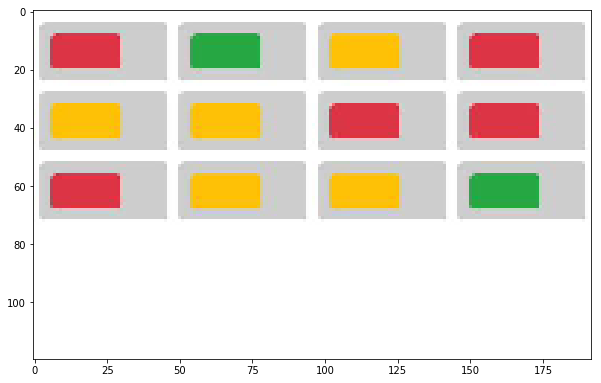

In [72]:
aa = [batch_examples[i].img_idx for i in sorted_idx]
plt.imshow(1 - images[aa[0]].permute((1, 2, 0)).clone().cpu().numpy())
print(aa)
# plt.imshow(1 - bimgs[0].permute((1, 2, 0)).clone().cpu().numpy())

In [73]:
i = sorted_idx[0]
e = batch_examples[i]
print(i, e.img_idx)

p = HTMLProgram.from_int_tokens([w for w in e.context_tokens if w > 0], ivocab)
assert e.context_tokens == bx[0].tolist()
gimg = oimages[e.img_idx]
eimg = p.render_img(render_engine)
matches = ((eimg == gimg).sum() / np.prod(eimg.shape))
assert matches == 1.0, matches

tensor(21, device='cuda:0') 1033


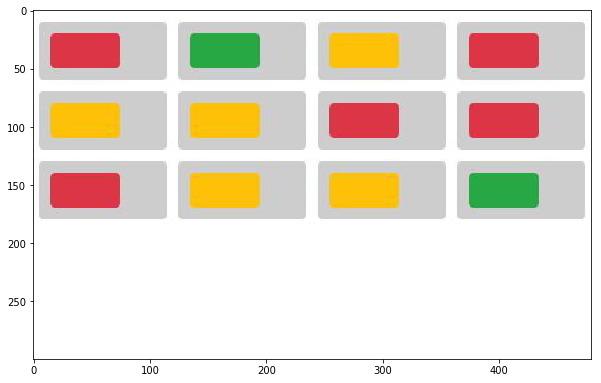

In [74]:
plt.imshow(gimg)

In [38]:
print(x)
print(batch_examples[sorted_idx[0]].context_tokens == x.tolist())

tensor([ 1,  8,  3,  7,  9, 11, 14, 10, 10,  7,  9, 13, 14, 10, 10,  7,  9, 12,
        14, 10, 10,  7,  9, 11, 14, 10, 10, 10,  3,  7,  9, 12, 14, 10, 10,  7,
         9, 12, 14, 10, 10,  7,  9, 11, 14, 10, 10,  7,  9, 11, 14, 10, 10, 10,
         3,  7,  9, 11, 14, 10, 10,  7,  9, 12, 14, 10, 10,  7,  9, 12, 14, 10,
        10,  7,  9, 13, 14, 10, 10, 10, 10], device='cuda:0')
True


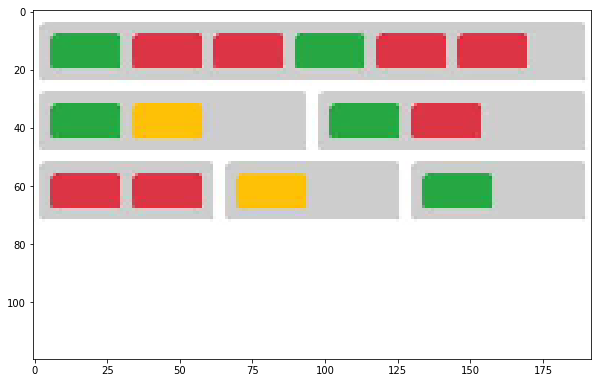

In [29]:
a = images[0].permute((1, 2, 0)).clone().cpu().numpy()
plt.imshow(1 - a)

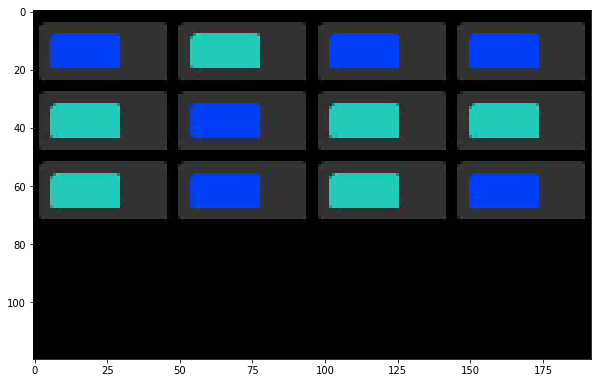

In [25]:
plt.imshow(eimg)

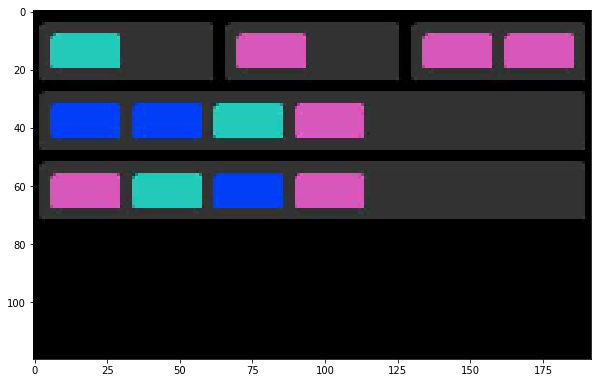

In [26]:
plt.imshow(gimg)

In [76]:
# TODO: uncomment to double check if iter_batch function is correct
# render_engine = RemoteRenderEngine.get_instance(tags[0].to_html(), 480, 300)
# for examples in [train_examples, valid_examples, test_examples]:
#     for bimgs, bx, bnx, bxlen, sorted_idx in tqdm(iter_batch(200, images, examples, True, device)):
#         for gimg, x in tqdm(zip(bimgs, bx), total=200):
#             p = HTMLProgram.from_int_tokens([w for w in x.tolist() if w > 0], ivocab)

#             gimg = gimg.permute((1, 2, 0)).clone().cpu().numpy()
#             eimg = shrink_img(norm_rgb_imgs(p.render_img(render_engine)), 0.4, cv2.INTER_NEAREST)
#             matches = ((eimg == gimg).sum() / np.prod(eimg.shape))
#             assert matches == 1.0, matches

KeyboardInterrupt: 

In [57]:
next_token_func = wrap_next_token_func(lambda bimgs, bx, bxlen: model2(bimgs, bx, bxlen))
results = synthesize(images[-1].to(cpu_device), oimages[-1], render_engine, ivocab, vocab, next_token_func, max_unexamined_program=3, top_k=5, beam_width=50, max_depth=80)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 1
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 3
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 4
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 5
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 6
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 7
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 8
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 9
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 10
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 11
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 12
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 13
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 14
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 15
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 16
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 17
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 18
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 19
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

0.9414560185185186
['<program>', '<div class="container-fluid">', '<div class="row">', '<div class="col-4">', '<div class="grey-background">', '<button class="btn btn-danger">', '</button>', '</div>', '</div>', '<div class="col-4">', '<div class="grey-background">', '<button class="btn btn-success">', '</button>', '</div>', '</div>', '<div class="col-4">', '<div class="grey-background">', '<button class="btn btn-warning">', '</button>', '<button class="btn btn-success">', '</button>', '</div>', '</div>', '</div>', '<div class="row">', '<div class="col-6">', '<div class="grey-background">', '<button class="btn btn-warning">', '</button>', '<button class="btn btn-danger">', '</button>', '</div>', '</div>', '<div class="col-6">', '<div class="grey-background">', '<button class="btn btn-success">', '</button>', '<button class="btn btn-success">', '</button>', '</div>', '</div>', '</div>', '<div class="row">', '<div class="col-4">', '<div class="grey-background">', '<button class="btn btn-w

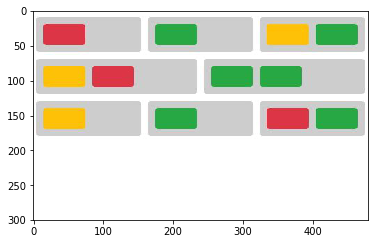

In [58]:
print(results[0].quality)
tokens = [ivocab[w] for w in results[0].to_int_tokens(vocab)]
print(tokens, len(tokens))
plt.imshow(results[0].render_img(render_engine))

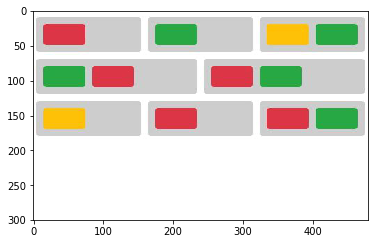

In [59]:
plt.imshow(oimages[-1])

In [11]:
ivocab

{0: '<pad>',
 1: '<program>',
 2: '</program>',
 3: '<div class="row">',
 4: '<div class="col-12">',
 5: '<div class="col-6">',
 6: '<div class="col-4">',
 7: '<div class="col-3">',
 8: '<div class="container-fluid">',
 9: '<div class="grey-background">',
 10: '</div>',
 11: '<button class="btn btn-danger">',
 12: '<button class="btn btn-warning">',
 13: '<button class="btn btn-success">',
 14: '</button>'}

#### DEBUG the program

Printing the image and allowing to discover next tags from the current program

['<program>', '<div class="container-fluid">', '<div class="row">', '<div class="col-4">', '<div class="grey-background">']
token_idx | next_token_str                                    | prob
       12 | <button class="btn btn-warning">                  | 0.36612
       13 | <button class="btn btn-success">                  | 0.32509
       11 | <button class="btn btn-danger">                   | 0.30744
        9 | <div class="grey-background">                     | 0.00032
       14 | </button>                                         | 0.00023
        4 | <div class="col-12">                              | 0.00023
        6 | <div class="col-4">                               | 0.00018
        5 | <div class="col-6">                               | 0.00009
       10 | </div>                                            | 0.00007
        2 | </program>                                        | 0.00006
        7 | <div class="col-3">                               | 0.00005
        8 | <di

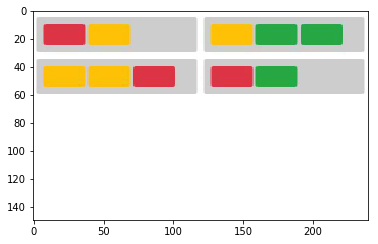

In [37]:
plt.imshow(1 - images[0].clone().detach().cpu().numpy().transpose(1, 2, 0))
program = HTMLProgram.from_int_tokens([1, 8, 3, 6, 9], ivocab)
print([ivocab[w] for w in program.to_int_tokens(vocab)])

program.print_next_tags(images[0], next_token_func, ivocab, vocab, device)

In [14]:
program = HTMLProgram.from_int_tokens([8, 3, 5, 9, 11], ivocab)
tag = program.to_linearized_tag()

In [119]:
gui = render_engine.render_page(tag)

In [120]:
gui = shrink_img(gui, 0.5)

In [121]:
gui.shape

(150, 240, 3)

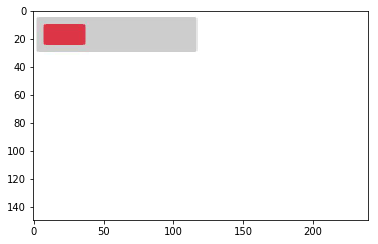

In [122]:
plt.imshow(gui)

In [123]:
ogui = shrink_img(oimages[0], 0.5)

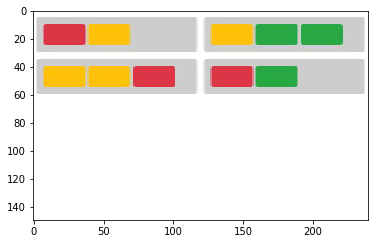

In [124]:
plt.imshow(ogui)

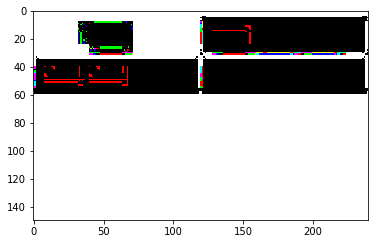

In [125]:
plt.imshow((gui == ogui).astype(np.float))

In [126]:
(gui == ogui).sum()

78933